In [8]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean


class ParticleFilter:
    def __init__(self, m_map, gaussian_params, num_particles, map_constraints, step_noise=0.2, step_length=1, gyro_noise=0.1, map_noise=0.2):
        """
        Initialize the particle filter.
        :param gaussian_params: Dict with Gaussian parameters {'mean_x', 'mean_y', 'std_x', 'std_y'}
        :param num_particles: Number of particles.
        :param map_constraints: Spatial constraints of the map (e.g., walls, paths).
        :param step_length: Average step length of a user.
        :param gyro_noise: Standard deviation of noise added to direction changes.
        :param map_noise: Standard deviation of noise in map matching.
        """
        self.m_map = m_map
        self.gaussian_params = gaussian_params  
        self.num_particles = num_particles
        self.map_constraints = map_constraints
        self.step_length = step_length
        self.gyro_noise = gyro_noise
        self.step_noise = step_noise
        self.map_noise = map_noise
        self.particles = self.initialize_particles()

    def initialize_particles(self):
        """
        Randomly initialize particles based on map constraints.
        """
        particles = []
        for _ in range(self.num_particles):
            while True:
                # Generate x and y from Gaussian distribution
                x = np.random.normal(self.gaussian_params['mean_x'], self.gaussian_params['std_x'])
                y = np.random.normal(self.gaussian_params['mean_y'], self.gaussian_params['std_y'])
                
                # Check if the generated coordinates are within the map constraints
                if self.map_constraints_check(x, y):
                    break

            # Random direction for the particle
            direction = np.arctan2(x - self.gaussian_params['mean_x'], y - self.gaussian_params['mean_y'])  # Direction in radians
            
            # Initialize the particle with weight 1.0
            particles.append({'x': x, 'y': y, 'direction': direction, 'weight': 1.0})
        return particles

    def move_particles(self, gyro_data):
        """
        Move particles based on step length and gyro data.
        """
        for idx, particle in enumerate(self.particles):

            # Update direction with gyro data and noise
            delta_direction = gyro_data + np.random.normal(0, self.gyro_noise)
            particle['direction'] += delta_direction

            # Move particle in updated direction
            dx = (self.step_length + self.step_noise) * np.cos(particle['direction'])
            dy = (self.step_length + self.step_noise) * np.sin(particle['direction'])
            particle['x'] += dx
            particle['y'] += dy


    def calculate_weights(self, observed_vector, m_map):
        """
        Calculate particle weights using DTW similarity.
        """
        for idx, particle in enumerate(self.particles):
            if self.map_constraints_check(particle['x'], particle['y'])==False:
                particle['weight'] = 0.000001
            else:
                # Simulate predicted vector (from M-Map) at particle's position
                predicted_vector = self.get_m_map_vector_(m_map, particle)  # Replace with map-based vector lookup


                observed_vector_mag_values = [item[1] for item in observed_vector] 
                observed_vector_mag_mean = sum(observed_vector_mag_values) / len(observed_vector_mag_values)  

                observed_vector_result = [[item[0], item[1] - observed_vector_mag_mean] for item in observed_vector]


                predicted_vector_mag_values = [item[1] for item in predicted_vector]  
                predicted_vector_mag_mean = sum(predicted_vector_mag_values) / len(predicted_vector_mag_values)  

                predicted_vector_result = [[item[0], item[1] - predicted_vector_mag_mean] for item in predicted_vector]
                # print(particle)
                # print("Observed Vector Result:", observed_vector_result)
                # print("Predicted Vector Result:", predicted_vector_result)

                distance, _ = fastdtw(observed_vector_result, predicted_vector_result, dist=euclidean)
                distance = round(distance*0.001, 4)
                print(distance)
                #need distance nomalization?
                particle['weight'] = np.exp(-distance**2 / (2 * self.map_noise**2))

    def resample_particles(self):
        """
        Resample particles based on their weights.
        """
        weights = np.array([p['weight'] for p in self.particles])
        weights /= np.sum(weights)  # Normalize weights


        # Resample particles based on weights
        indices = np.random.choice(len(self.particles), size=self.num_particles, p=weights)
        new_particles = [self.particles[i] for i in indices]

        # Add some noise to resampled particles to avoid over-concentration
        for particle in new_particles:
            particle['x'] += np.random.normal(0, self.map_noise)
            particle['y'] += np.random.normal(0, self.map_noise)

        self.particles = new_particles

    def estimate_position(self):
        """
        Estimate user position based on particle distribution.
        """

        # for particle in self.particles:
        #     print(particle)


        weights = np.array([p['weight'] for p in self.particles])
        x_mean = np.sum([p['x'] * p['weight'] for p in self.particles]) / np.sum(weights)
        y_mean = np.sum([p['y'] * p['weight'] for p in self.particles]) / np.sum(weights)


        # x_mean = np.mean([p['x'] * p['weight'] for p in self.particles]) / np.sum(weights)
        # y_mean = np.mean([p['y'] * p['weight'] for p in self.particles]) / np.sum(weights)
        return x_mean, y_mean




    def run_filter(self, observed_vector, gyro_data):
        """
        Run the particle filter over a sequence of observations.
        """
        positions = []
        self.move_particles(gyro_data)
        self.calculate_weights(observed_vector, self.m_map)
        self.resample_particles()
        positions.append(self.estimate_position())
        return positions


    def interpolate_m_map(file_path):
        df = pd.read_csv(file_path)
        return df


    def map_constraints_check(self, x, y):

        """
        if the (x,y) impossible return false  
        
        
        """

        return True
    
    def get_m_map_vector_(self, m_map, particle):
        vector = []

        dx = self.step_length * np.cos(particle['direction'])
        dy = self.step_length * np.sin(particle['direction'])

        x1 = particle['x'] - dx
        y1 = particle['y'] - dy
        
        x2 = particle['x']
        y2 = particle['y']

        

        """
        find the points from (x1, y1) to (x2, y2) 
        concat the magnitudes of points


        """
        m_map_df = pd.DataFrame(m_map, columns=['X', 'Y', 'mag'])

        # (x1, y1)에서 (x2, y2)까지 이동하는 단계 수 계산
        num_steps = 10


        # m_map의 magnitude 값을 읽어서 벡터화
        for i in range(num_steps + 1):
            # 시작점과 끝점 사이를 보간하여 (x, y) 계산
            x = np.round(x1 + (x2 - x1) * i / num_steps, 1)
            y = np.round(y1 + (y2 - y1) * i / num_steps, 1)
            
            x = float(x) if isinstance(x, np.ndarray) else x
            y = float(y) if isinstance(y, np.ndarray) else y



            magnitude = m_map_df.loc[(m_map_df['X']==x) & (m_map_df['Y']==y), 'mag'].values


            # magnitude 값을 벡터에 추가
            vector.append([i, magnitude[0]])




        
        return vector



In [2]:
def slice_csv_by_time(file_path, start_time, end_time, time_column='seconds_elapsed'):
    df = pd.read_csv(file_path)
    vector = []
    filtered_df = df[(df[time_column] >= start_time) & (df[time_column] <= end_time)].copy()

    filtered_df.reset_index(drop=True, inplace=True)


    filtered_df['Magnitude'] = np.sqrt(filtered_df['x']**2 + filtered_df['y']**2 + filtered_df['z']**2)
    
    for index, mag in filtered_df['Magnitude'].items():
        vector.append([index, mag])

    return vector

    

0.2606
0.2592
0.2585
0.2615
0.2617
0.2738
0.2644
0.2628
0.2683
0.2743
0.2682
0.2708
0.2735
0.2606
0.2681
0.2769
0.2699
0.3106
0.2684
0.287
0.273
0.2671
0.2718
0.2901
0.3525
0.2696
0.2702
0.2651
0.259
0.2605
0.2607
0.2649
0.3083
0.261
0.2585
0.2621
0.2659
0.2859
0.2584
0.26
0.2639
0.2585
0.2601
0.2661
0.2887
0.2585
0.2587
0.3477
0.2586
0.258
0.2923
0.2581
0.2587
0.2797
0.2988
0.2627
0.2736
0.2595
0.2785
0.2958
0.2641
0.2614
0.2681
0.2668
0.3072
0.2609
0.2848
0.2668
0.2655
0.2669
0.2644
0.2614
0.2715
0.262
0.2725
0.2739
0.265
0.2584
0.2581
0.2632
0.2652
0.2596
0.2803
0.2918
0.31
0.267
0.2657
0.2586
0.2587
0.2901
0.2676
0.2716
0.2587
0.2845
0.2678
0.2581
0.2586
0.2829
0.2744
0.2624
0.2725
0.2921
0.2674
0.2603
0.2595
0.2843
0.266
0.2642
0.3017
0.2658
0.2761
0.2594
0.2629
0.2592
0.2666
0.3341
0.2819
0.2642
0.2591
0.274
0.3331
0.2973
0.2708
0.2757
0.264
0.2601
0.2843
0.268
0.2904
0.2824
0.2672
0.2627
0.2605
0.2773
0.2612
0.2994
0.2601
0.2667
0.2616
0.2704
0.2777
0.2667
0.2599
0.2734
0.3086
0

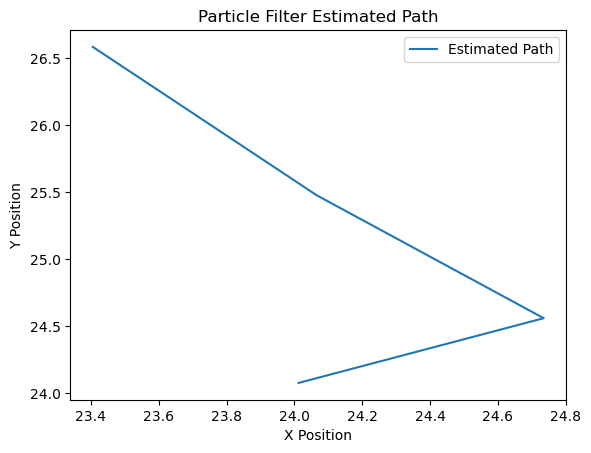

In [10]:
# Example usage
if __name__ == "__main__":
    # Map constraints
    map_constraints = {
        'x_min': 0,
        'x_max': 100,
        'y_min': 0,
        'y_max': 100
    }

    # Simulated data
    gyro_data = np.random.normal(0, 0.1, size=1)  # Replace with real gyro data

    m_map = pd.read_csv("M_map_version2.csv")
    gaussian_params = {"mean_x": 24, "mean_y":24, "std_x": 1, "std_y": 1}

    start_time = 0
    time_interver = 0.5
    observed_vectors = slice_csv_by_time("Path3_freeOri_A31-2024-11-29_09-48-36 (1)/Magnetometer.csv", start_time,start_time+time_interver)

    # Initialize particle filter
    pf = ParticleFilter(num_particles=300, gaussian_params=gaussian_params, m_map=m_map, map_constraints=map_constraints)

    estimated_positions = []
    for st in np.arange(0.0, 2.0, 0.5):
        observed_vectors = slice_csv_by_time("Path3_freeOri_A31-2024-11-29_09-48-36 (1)/Magnetometer.csv", st,st + 0.5)
        estimated_positions.append(pf.run_filter(observed_vectors, 0))
        print('st')
        


    # # Run the filter
    # estimated_positions = pf.run_filter(observed_vectors, gyro_data)

    # Plot results
    estimated_positions = np.array(estimated_positions)
    estimated_positions = np.squeeze(estimated_positions)  # (n, 2)로 변환

    print(estimated_positions)
    plt.plot(estimated_positions[:, 0], estimated_positions[:, 1], label="Estimated Path")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.legend()
    plt.title("Particle Filter Estimated Path")
    plt.show()


In [ ]:
temp_df = pd.read_csv("position_data (13).csv")


